# **Stackoverflow keyword extraction**
 
**Description** <br>
Stackoverflow is the largest online community of developers where they can ask questions, learn and share their programming knowledge. It is a platform
that every programmer uses in their workflow. With over 4 million registeres users, the platform caters exchange of over 10 million questions in a year. To make things easy to understand, the platform automatically tag each question based on the topic. Based on the type of tags, some of the most used tags are: java, python, javascript, etc. 

**Problem statement** <br>
Analyse the information in the question title and body to assign tags to new questions in the future.

**Business value** <br>
It is job of the platform to route the right question to right users. E.g. you don't want to be sending a java related question to javascript developer. That would be a huge miss and will affect the user experience of the platform. Stackoverflow can make use of topic information about a question to forward it to the subject matter expert. This is why the problem of predicting tags is of high value to ensure a good user experience. 
    

## 1. Pre-processing features (Question Title and Body)

In [2]:

%cd ..


/home/mluser/projects/Keywork-Extraction-Kaggle-Stackoverflow


In [3]:
#import some libraries
import pickle
import pandas as pd
from datatable import by, dt, f
import datatable, os, pandas as pd, numpy as np
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns

## dask dataframe parallel processing
import dask.dataframe as dd
from dask.distributed import Client
from dask.multiprocessing import get

## Text processing
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize # to break sentences into words

## split data
from dask_ml.model_selection import train_test_split

## sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

## Base model without any hyperparameter tuning

from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

from src.evaluation import print_eval

In [75]:
data_r = datatable.fread("./input/data_no_dupes_top50.csv")
data = data_r[:, f[:].remove([f["#tags"], f["count_duples"], f[ "Tags"]])]

data.head(2)

,Title,Body,c#,java,php,javascript,android,jquery,c++,python,…,asp.net-mvc-3,image,html5,networking,homework
,▪▪▪▪,▪▪▪▪▪▪▪▪,▪,▪,▪,▪,▪,▪,▪,▪,,▪,▪,▪,▪,▪
0,Implementing Boundary Value Analysis of Softw…,<pre><code>#include&lt;iostream&gt; #include&lt;st…,0,0,0,0,0,0,1,0,…,0,0,0,0,0
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamically at…,1,0,0,0,0,0,0,0,…,0,0,0,0,0


### 1.1 Plot class proportions and imbalances

/tmp/ipykernel_36157/3335243169.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{i:.0%}" for i in __])


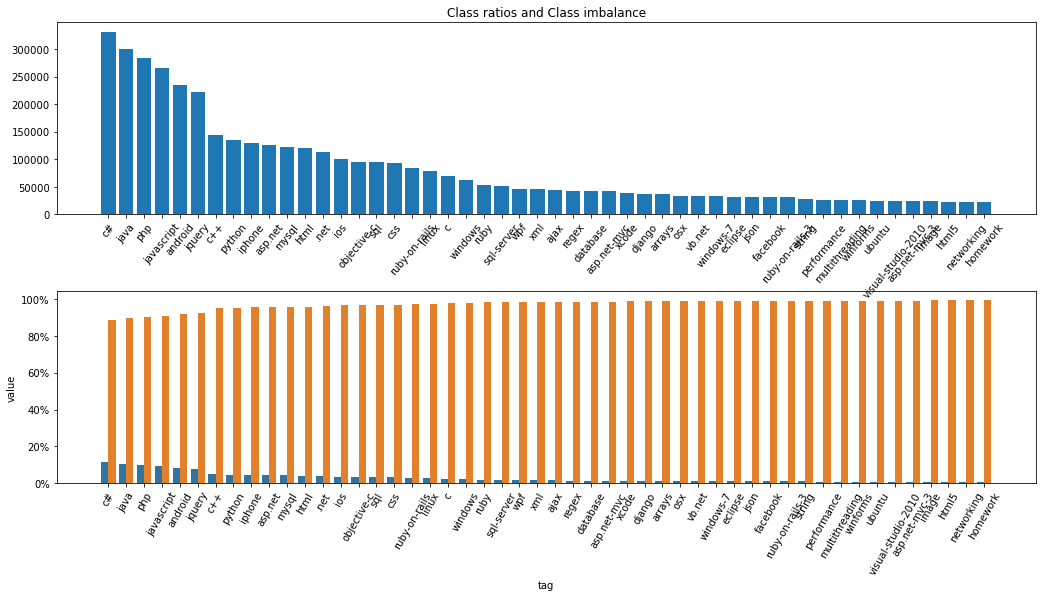

In [19]:
# requires a datatable object
def plot_class_ratio_balance(_):
    plt.figure(figsize=(17, 8))

    plt.subplot(212)

    _res = dt.rbind(_[:, dt.sum(f[:])], _[:, dt.count(f[:])])
    _res_pd = _res.to_pandas().T.reset_index().rename(columns = {0: "occur", 1: "total", "index": "tag"})
    _res_pd = _res_pd.assign(no_occur = _res_pd.total - _res_pd.occur, prop = _res_pd.occur / _res_pd.total)
    _res_pd_melt = pd.melt(_res_pd, id_vars = "tag", value_vars=["occur", "no_occur"])
    ax = sns.barplot(data = _res_pd_melt.assign(value = lambda r: r.value / _.shape[0]), x = "tag", y = "value", hue="variable")
    plt.xticks(rotation=60)
    __ = ax.get_yticks()
    ax.set_yticklabels([f"{i:.0%}" for i in __])
    leg = plt.legend()
    leg.remove()

    plt.subplot(211, sharex = ax)
    plt.bar(_.sum().names, _.sum().to_numpy()[0])
    plt.xticks(rotation=50)

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

    plt.title("Class ratios and Class imbalance")

    plt.show()

# X = data[:, ["Title", "Body"]]
# Y = data[:, data.names[2:]]

plot_class_ratio_balance(data[:, data.names[2:]])

### 1.2 Sample 500k questions from overall data

__The best way to sample (theoretically)__

Sampling pays a key role in practical machine learning and data mining. 
* Efficient data processing for training models
* Generation of training, validation and test sets
 
The stratified version of sampling is typically used in classification tasks.
* Class proportions remain the same in sampled and raw data
* It has been found to improve standard CV both in terms of bias and variance

http://videolectures.net/ecmlpkdd2011_tsoumakas_stratification/?q=stratification%20multi%20label
  
   
__BUT Computation constraints__
 
We will be randomly sampling 1 million datapoints, because stratified sampling has an exponential complexity. (after trial and error)

__For simplication, we will sample 100 million questions from the overall 2.3M questions__

In [21]:
# Number of datapoints we want

500000 / data.shape[0]

0.1734377937602632

We only need 17 percent, or __500k datapoints__ of the overall data to proceed further. The reason is that in the further steps, we are
going to featurize the text data in X, which will drastically increase the complexity of the analysis. Plus, we 
have a lot of data, so we can afford to sample down to perform analysis.

In [22]:
# We will make use of dask to perform sampling

# divide the data into partitions and take around 35 percent data from each partition

data_pd = data.to_pandas().reset_index() # just to make sure of order
data_pd.iloc[:, 3:] = data_pd.iloc[:, 3:].astype(int)
data_pd.head(1)

,index,Title,Body,c#,java,php,javascript,android,jquery,c++,...,performance,multithreading,winforms,ubuntu,visual-studio-2010,asp.net-mvc-3,image,html5,networking,homework
0,0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


We only perform order 1 level stratification, to reduce complexity. `The above operation took 90 minutes to complete.`

In [25]:
# sample data from df
def sampler(df, p):
    return df.sample(frac = p)

# partition the data into 12 parts
ddata_pd = dd.from_pandas(data_pd, npartitions=12)
# pick 30% of data from each partition randomly
res = ddata_pd.map_partitions(lambda df, p: sampler(df, p), p = 0.18).compute(scheduler="threads")


In [26]:
res.shape

(518916, 53)

We were able to sample 1 million points from original data in 9 seconds

/tmp/ipykernel_36157/3335243169.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{i:.0%}" for i in __])


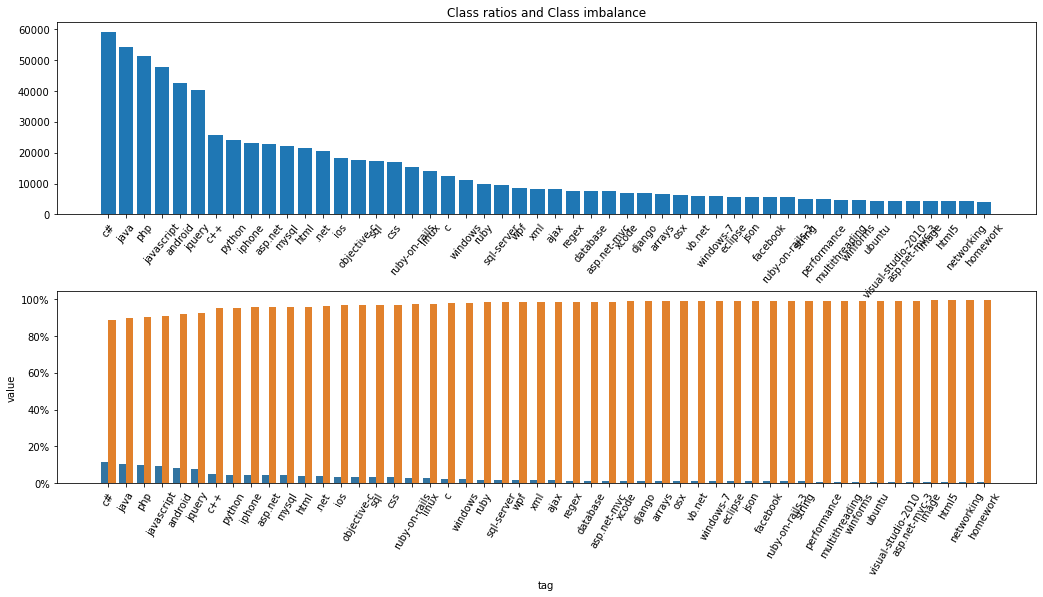

In [27]:
plot_class_ratio_balance(datatable.Frame(res.loc[:, res.columns[3:]]))

The good thing is that the class ratio are representative of the original dataset

In [32]:
# Save the data

res.to_csv("./input/500k_data_no_dupes_top50.csv")

In [5]:
# upload to blob storage

filename = "500k_data_no_dupes_top50.csv"
%run ./src/blob_handle.py --operation "upload" --filename $filename

Upload to container: 'projectkeywordextraction' is in progress... 

File upload complete


In [7]:
# load the data

res = datatable.fread("./input/500k_data_no_dupes_top50.csv").to_pandas()

The 500k data is around __700MB__ in size

### 1.3 Divide data into X and Y

In [8]:
res.drop(columns = ["index"], inplace=True)
res.reset_index(drop=True, inplace = True)

In [18]:
X, Y = res.iloc[:, :2], res.iloc[:, 2:] 
X.shape, Y.shape

((518916, 2), (518916, 50))

### 1.4 Cleaning the input data X
Now that we have sampled a manageble proportion of data from the orignal set, we are going to perform operations to clean the input data matrix X. Since, we only have text features, we will perform the following set of operations on each row. 
 
Again we will make use of dask library to speed things up a notch.

https://medium.com/mindorks/speeding-up-text-pre-processing-using-dask-45cc3ede1366#

Steps - 

- Sample ----  _Done_
- Remove code snippets
- Remove special characters from remaining text
- Remove stop words
- remove HTML tags
- convert to lowercase
- Stem the words using snowball stemmer

In [22]:
def striphtml(data):
    # find the html tags and remove them
    patt = re.compile('<.*?>')
    cleantxt = re.sub(patt, ' ', str(data))
    return cleantxt

def clean_row(row):
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer("english")

    # questions_with_code =  0
    # len_before = 0
    len_after = 0

    is_code = 0
    title, question = row[0], row[1]

    if "<code>" in question:
        # questions_with_code += 1
        is_code = 1

    x = len(question) + len(title)
    # len_before += x

    # Find the code piece of question
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    # remove the code
    question = re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)

    title=title.encode('utf-8')

    # combine question and title, remove special characters, convert to lowercase
    queti = str(title) + str(question)
    queti = re.sub(r'[^A-Za-z]+',' ',queti).lower()

    # get words
    words = word_tokenize(str(queti))

    #Removing all single letter and and stopwords from question except for the letter 'c'
    queti_stop = ' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_after += len(queti_stop)

    # question_title(clean), len(cleaned), len_before, if_has_code, code
    return queti_stop, len(queti_stop), x, is_code, code


In [23]:
# run the calculation across

dX = dd.from_pandas(X, npartitions=12)
Xres = dX.map_partitions(lambda df: df.apply(lambda row: clean_row(row), axis = 1, result_type="expand")).compute(scheduler="threads")

Time taken for above transformation is `10 minutes`

In [24]:
Xres.columns = ['queti_stop', 'len_queti_stop', 'len_pre', 'is_code', 'code']
Xres.head(2)

,queti_stop,len_queti_stop,len_pre,is_code,code
0,add schedul task setup littl c applic creat sc...,148,351,0,[]
1,run time adjust dimens uipickerview ui window ...,97,181,0,[]


In [27]:
# Save the data

Xres.to_csv("./input/500k_X_clean_top50.csv")
Y.to_csv("./input/500k_Y_clean_top50.csv")

In [3]:
# read data 

Xres = pd.read_csv("./input/500k_X_clean_top50.csv")
Y = pd.read_csv("./input/500k_Y_clean_top50.csv")

### 1.5 Create train and test sets

We split the data by a 80:20 split with 80 percent of data for training/validation and rest for testing

In [16]:
%%time

Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xres, Y, test_size=0.20, random_state=42)
Ytrain = Ytrain.iloc[:, 1:]
Ytest = Ytest.iloc[:, 1:]
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

CPU times: user 162 ms, sys: 7.89 ms, total: 170 ms
Wall time: 169 ms


((415132, 6), (415132, 50), (103784, 6), (103784, 50))

Now the data has been split into train and test splits. We are ready to create features from the data X

### 1.6 Featurizing the text data
We wil be using TF-IDF based featurizatiom of the text data followed by a feature selection phase to select
only the relevant features for the analysis

In [5]:
vectorizer = TfidfVectorizer(min_df=0.00009, ngram_range=(1, 2), tokenizer = lambda x: x.split(), max_features=200000, \
                smooth_idf = True, sublinear_tf = False, norm = "l2")


## get corpus
xtrain_text = Xtrain["queti_stop"].tolist()
xtest_text = Xtest["queti_stop"].tolist()

## apply Tf-Idf
xtrain_text_v = vectorizer.fit_transform(xtrain_text)
xtest_text_v = vectorizer.transform(xtest_text)

del xtrain_text, xtest_text


In [17]:
print(type(xtrain_text_v))
xtrain_text_v.shape, xtest_text_v.shape

<class 'scipy.sparse.csr.csr_matrix'>


((415132, 84363), (103784, 84363))

`Above`, the result is stored in sparse matrix format.<br>
After running TF-Idf, each line of text is transformed to a sparse vector of length 98000

In [7]:
try:
    xtrain_text_v.todense()
except Exception as e:
    print(e)

Unable to allocate 261. GiB for an array with shape (415132, 84363) and data type float64


> The data is so big that it is not even possible to convert it back to dense form

In [8]:
text_features = vectorizer.get_feature_names_out()
text_features[:10]

array(['aa', 'aa aspx', 'aa c', 'aa vs', 'aaa', 'aaa bbb', 'aaaa', 'aac',
       'aaron', 'ab'], dtype=object)

### 1.7 Feature selection
The Tf-Idf returned a massive vector with row length of 98000. Now, in order to achieve good results and prevent overfitting, we need 
to do some kind of feature selection to take only the features that are somehow useful to predict the targets.
 
To do feature selection, we have two options - 
1. Mutual information test
2. Chi square test

We will go ahead and use the chi-sq test of independence, since it is faster and performs well if data size is reasonable.

In [18]:
Ytrain = Ytrain.astype(int)
Ytest = Ytest.astype(int)

In [20]:
xtrain_text_v, Ytrain.shape

(<415132x84363 sparse matrix of type '<class 'numpy.float64'>'
 	with 25887863 stored elements in Compressed Sparse Row format>,
 (415132, 50))

In [21]:
# iterate through each of the classes
res_fs = []
for ii, class_col in enumerate(Ytrain):
    print(f"{ii+1} Running for class - ", class_col + " "*20, end = "\r")
    _ = [class_col]
    chi, p = chi2(xtrain_text_v, Ytrain[class_col])
    _.extend(p)
    res_fs.append(_)

In [22]:
chi_df = pd.DataFrame(res_fs, columns=(["tags"] + text_features.tolist()))

In [23]:
chi_df.head(2)

,tags,aa,aa aspx,aa c,aa vs,aaa,aaa bbb,aaaa,aac,aaron,...,zoomabl,zsh,zurb,zxing,zygoteinit,zygoteinit java,zygoteinit main,zygoteinit methodandargscal,zz,zzz
0,c#,0.000079,0.000079,0.726017,0.000630,0.345370,0.404508,0.936000,0.201158,0.705651,...,0.405396,0.184558,0.242829,0.114645,0.273001,0.461015,0.575678,0.576367,0.880166,0.773211
1,java,0.385127,0.429205,0.688829,0.229135,0.912494,0.874731,0.593057,0.397260,0.715149,...,0.928816,0.206241,0.265883,0.224884,0.343648,0.451413,0.641468,0.638588,0.561066,0.661428


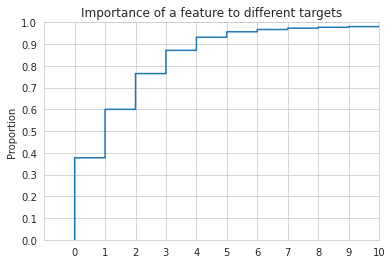

In [24]:
sns.set_style("whitegrid")
sns.ecdfplot((chi_df.iloc[:, 1:] < 0.05).sum())
plt.title("Importance of a feature to different targets")
plt.xlim(-1, 10)
plt.xticks(range(0, 11))
plt.yticks([i/10 for i in range(0, 11)])
plt.show()

In [27]:
_ = (chi_df.iloc[:, 1:] <= 0.05).sum().replace([0], np.nan).dropna().sort_values()
chi_df.shape[1], "now -- >" ,_.shape[0]

(84364, 'now -- >', 52539)

`Using above logic`, we only select a feature if it is useful to more than 3 models. Later we can try to change it to see if adding more feature improves performance.

In [28]:
_selected_features = _.index.tolist()
_selected_features[:4]

['mac termin', 'made href', 'made function', 'made form']

In [29]:
# store index of text features for easy access

text_features = text_features.tolist()
text_features_index = {}
for i, e in enumerate(text_features):
    text_features_index[e] = i

In [30]:
## convert the selected features to dense format for train and test sets

from tqdm.notebook import tqdm

_selected_features_index = []
for s in (_selected_features):
    _selected_features_index.append(text_features_index[s])

_selected_features_index[:4]

[42029, 42150, 42149, 42148]

In [31]:
xtrain_text_v_10k = xtrain_text_v[:, _selected_features_index]
xtest_text_v_10k = xtest_text_v[:, _selected_features_index]

xtrain_text_v_10k

<415132x52539 sparse matrix of type '<class 'numpy.float64'>'
	with 21655785 stored elements in Compressed Sparse Row format>

In [12]:
# save data

pickle.dump(_selected_features, open('./input/_selected_features.pickle', 'wb'))
pickle.dump(xtrain_text_v_10k, open('./input/xtrain_text_v_10k.pickle', 'wb'))
pickle.dump(xtest_text_v_10k, open('./input/xtest_text_v_10k.pickle', 'wb'))

Ytrain.to_csv('./input/Ytrain.csv')
Ytest.to_csv('./input/Ytest.csv')

In [3]:
# read saved data
import pickle

_selected_features = pickle.load(open('./input/_selected_features.pickle', 'rb'))
xtrain_text_v_10k = pickle.load(open('./input/xtrain_text_v_10k.pickle', 'rb'))
xtest_text_v_10k = pickle.load(open('./input/xtest_text_v_10k.pickle', 'rb'))

Ytrain = pd.read_csv('./input/Ytrain.csv')
Ytest = pd.read_csv('./input/Ytest.csv')

In [4]:
#Ytrain = Ytrain.iloc[:, 2:]
#Ytest = Ytest.iloc[:, 2:]
Ytrain.shape, Ytest.shape

((415132, 50), (103784, 50))

## 2. Getting predictions
As a first step towards model building, we will train a basic machine learning model which is SGD, 
and we will run it with two different loss functions: log-loss and hinge loss, to see which performs better on the data.
We want to test **if**:
1. Using **dimensionality reduction help** us to improve the performance of the baseline model ?
2. If yes, then which dimensionality reduction method we should be using: PCA, or UMAP, or LDA ?
 
Another focus of this section is to create a basic model and create a evaluation methodology to test:
1. **How good** the model is overall ?
2. What is the performance for **different tags** ?
3. What are the most **important features** for each of the classes ?

In [165]:
## Base model without any hyperparameter tuning

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

# train 50 independent classifiers

# balanced with more weigh given to miniority classes
classifier_b = MultiOutputClassifier(SGDClassifier(loss='log', alpha=0.0001, penalty='l1', class_weight='balanced'), n_jobs=-1)
# no balancing done using weights
classifier_nb = MultiOutputClassifier(SGDClassifier(loss='log', alpha=0.0001, penalty='l1'), n_jobs=-1)
# using a custom balance scheme to see where it fits
# class weight is a possible hyper parameter
#classifier_cb = MultiOutputClassifier(SGDClassifier(loss='log', alpha=0.0001, penalty='l1', class_weight={True: 0.80, False: 0.20}), n_jobs=-1)

classifier_b.fit(xtrain_text_v_10k, Ytrain)
classifier_nb.fit(xtrain_text_v_10k, Ytrain)
#classifier_cb.fit(xtrain_text_v_10k, Ytrain)

MultiOutputClassifier(estimator=SGDClassifier(class_weight={False: 0.2,
                                                            True: 0.8},
                                              loss='log', penalty='l1'),
                      n_jobs=-1)

In [37]:
comp_res = []

In [ ]:
# save the models to save time in future

pickle.dump(classifier_b, open("./model/classifier_b.pickle", "wb"))
pickle.dump(classifier_nb, open("./model/classifier_nb.pickle", "wb"))
#pickle.dump(classifier_cb, open("./model/classifier_cb.pickle", "wb"))

In [4]:
# read the saved models

classifier_b = pickle.load(open("./model/classifier_b.pickle", "rb"))
classifier_nb = pickle.load(open("./model/classifier_nb.pickle", "rb"))
#classifier_cb = pickle.load(open("./model/cl/'/assifier_cb.pickle", "rb"))

### 2.1 Logistic Regression, no class weights
For this model, we just pass the data without accounting for the class imbalance

**************************************************
Hamming loss:  0.02135608571648809
Micro Precision:  0.8096125128931447
Micro Recall:  0.3481766902359577
Micro F1 score:  0.4869421900824533
**************************************************


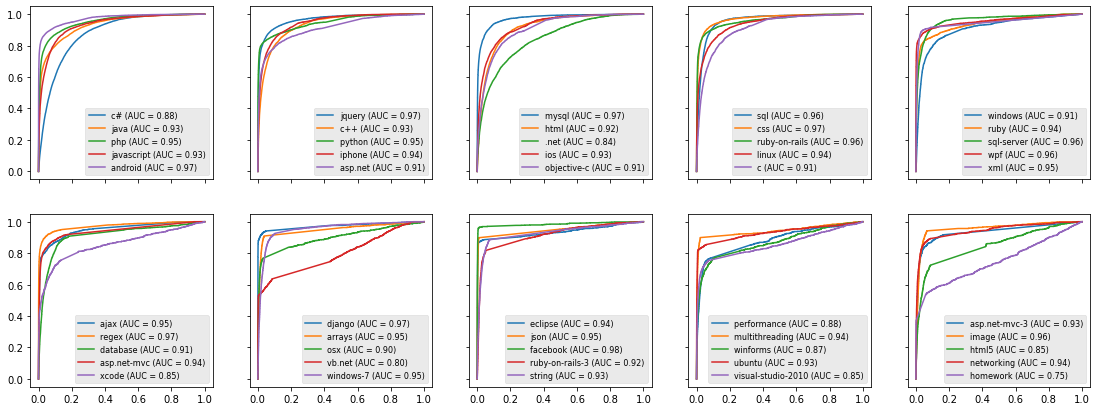

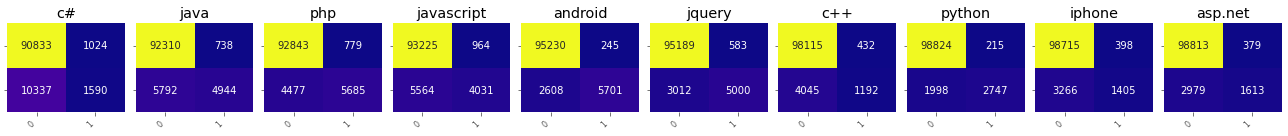

In [7]:
print_eval(classifier_nb, xtrain_text_v_10k, Ytrain, xtest_text_v_10k, Ytest)

In [38]:
comp_res.append(("Log-Loss-not-balanced", 0.80, 0.34, 0.48))

Observations - 
1. All models on average suffer from High precision, Low recall - means, model make right predictions but do not take risk for hard predictions
2. micro avg P, R, F1 -- 0.809613,	0.348177,	0.486942

### 2.2 Logistic Regression, balanced class weights
For this model, we just pass the data but account for the class imbalance

**************************************************
Hamming loss:  0.07403626763277577
Micro Precision:  0.2624251799044993
Micro Recall:  0.8525065543815047
Micro F1 score:  0.40131458998536756
**************************************************


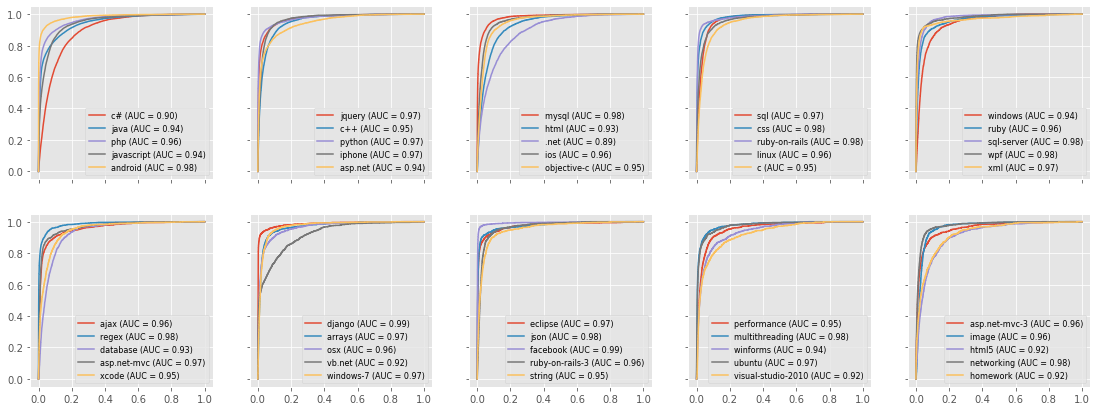

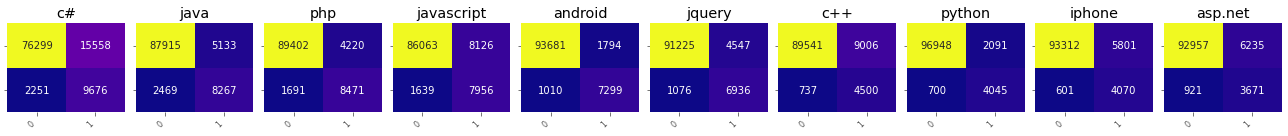

In [8]:
print_eval(classifier_b, xtrain_text_v_10k, Ytrain, xtest_text_v_10k, Ytest)

`AUC score has improved`

In [39]:
comp_res.append(("Log-Loss-balanced", 0.26, 0.85, 0.40))

After using balanced approach, the precision improved but both recall and f1 score dropped drastically

### 2.3 SVM Classifier, balanced class weights

In [14]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

classifier_b_svm = MultiOutputClassifier(LinearSVC(penalty='l1', class_weight='balanced'), n_jobs=-1)

classifier_b_svm.fit(xtrain_text_v_10k, Ytrain)

Pipeline(steps=[('scaler', Normalizer()),
                ('clf',
                 MultiOutputClassifier(estimator=SGDClassifier(class_weight='balanced',
                                                               loss='log',
                                                               penalty='l1'),
                                       n_jobs=-1))])

In [7]:
# save the models to save time in future

pickle.dump(classifier_b_svm, open("./model/classifier_b_svm.pickle", "wb"))

In [7]:
# load model

classifier_b_svm = pickle.load(open("./model/classifier_b_svm.pickle", "rb"))

**************************************************
Hamming loss:  0.03312090495644801
Micro Precision:  0.4618168484737373
Micro Recall:  0.8338563597362358
Micro F1 score:  0.5944229049316962
**************************************************


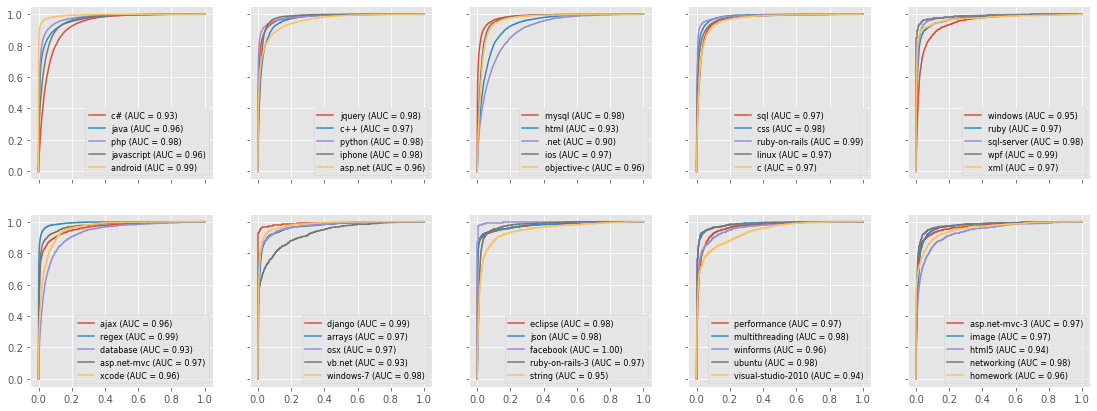

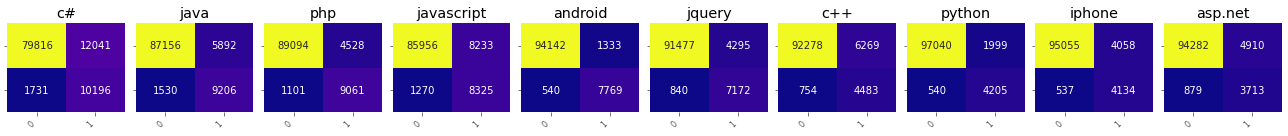

In [10]:
print_eval(classifier_b_svm, xtrain_text_v_10k, Ytrain, xtest_text_v_10k, Ytest)

In [40]:
comp_res.append(("SVM-balanced", 0.46, 0.83, 0.59))

By using Linear SVM, we see a significant boost in the F1 score as well as the precision

### 2.4 SVM Classifier Chains, balanced class weights

In [24]:
## Implement classifier chain for SVM
from sklearn.multioutput import ClassifierChain
from sklearn.svm import LinearSVC

classifier_b_svm_chains = ClassifierChain(LinearSVC(penalty='l2', class_weight='balanced'))
classifier_b_svm_chains.fit(xtrain_text_v_10k, Ytrain)

ClassifierChain(base_estimator=LinearSVC(class_weight='balanced'))

In [25]:
# save the models to save time in future

pickle.dump(classifier_b_svm_chains, open("./model/classifier_b_svm_chains.pickle", "wb"))

In [35]:
from sklearn import metrics

y_true = Ytest
y_pred = classifier_b_svm_chains.predict(xtest_text_v_10k)

print("*"*50)
print("Hamming loss: ", metrics.hamming_loss(y_true, y_pred))
# print("Ranked avg precision: ", label_ranking_average_precision_score(y_true, y_pred))
print("Micro Precision: ", metrics.precision_score(y_true, y_pred, average='micro', zero_division=0))
print("Micro Recall: ", metrics.recall_score(y_true, y_pred, average='micro'))
print("Micro F1 score: ", metrics.f1_score(y_true, y_pred, average='micro', zero_division=0))
print("*"*50)

**************************************************
Hamming loss:  0.028316118091420643
Micro Precision:  0.5092176036924293
Micro Recall:  0.7508805381213421
Micro F1 score:  0.6068758862402012
**************************************************


In [41]:
comp_res.append(("SVM-balanced-Chained", 0.51, 0.75, 0.60))

Using SVM with chains, we can see that there is 6 percent boost in precision but recall also dropped around 8 percent, with minor improvements in F1 score. So, chaining does help the models make better predictions.

In [43]:
pd.DataFrame(comp_res, columns = ['method', 'precision', 'recall', 'f1-score'])

,method,precision,recall,f1-score
0,Log-Loss-not-balanced,0.80,0.34,0.48
1,Log-Loss-balanced,0.26,0.85,0.40
2,SVM-balanced,0.46,0.83,0.59
3,SVM-balanced-Chained,0.51,0.75,0.60


__`Failed experiments :`__
- **PCA** for dimensionality reductions: fails because of memory limitations
- **Random Projections**: no significant performance immprovements
- **Stacking predictions** of above models: no significant performance improvements
- **Tree algorithms**: High training time requirements, not feasible

---
---

## **Experiments below**

#### 2.5.1 Train doc2vec on the cleaned data
We make use of bigram phrase capture to capture important phases

In [4]:
# read cleaned data, which we processed before TF-idf and splitting into 

Xres = pd.read_csv("./input/500k_X_clean_top50.csv")
Y = pd.read_csv("./input/500k_Y_clean_top50.csv")

In [6]:
%%time

Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xres, Y, test_size=0.20, random_state=42)
Ytrain = Ytrain.iloc[:, 1:]
Ytest = Ytest.iloc[:, 1:]
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

CPU times: user 137 ms, sys: 8.08 ms, total: 146 ms
Wall time: 144 ms


((415132, 6), (415132, 50), (103784, 6), (103784, 50))

In [7]:
cleaned_text_train = Xtrain.queti_stop
cleaned_text_test = Xtest.queti_stop

cleaned_text_train[:3]

389212    altern exist data generat plan visual studio e...
193389    creat contact programmat blockquot strong poss...
43713     covari java follow work java would work c pre ...
Name: queti_stop, dtype: object

In [15]:
from tqdm.notebook import tqdm

# [ ['I', 'am' ..], [..], ... ]
corpus_train = []
tags_train = []
i = 0
for s in tqdm(cleaned_text_train):
    corpus_train.append(word_tokenize(s))
    tags_train.append(Ytrain.columns[Ytrain.iloc[i]].tolist())
    i += 1

corpus_train = np.array(corpus_train)
tags_train = np.array(tags_train)

corpus_train[0], tags_train[:3]

  0%|          | 0/415132 [00:00<?, ?it/s]

(['altern',
  'exist',
  'data',
  'generat',
  'plan',
  'visual',
  'studio',
  'express',
  'user',
  'wonder',
  'good',
  'option',
  'us',
  'use',
  'express',
  'even',
  'profession',
  'edit',
  'without',
  'go',
  'outsid',
  'visual',
  'studio',
  'project',
  'write',
  'rubi',
  'perl',
  'etc',
  'script',
  'popul',
  'test',
  'seed',
  'data',
  'help',
  'work',
  'c',
  'net',
  'mvc',
  'app',
  'within',
  'ms',
  'web',
  'develop'],
 array([list(['c#', 'asp.net']), list(['android']), list(['java'])],
       dtype=object))

In [16]:
from tqdm.notebook import tqdm

# [ ['I', 'am' ..], [..], ... ]
corpus_test = []
tags_test = []
i = 0
for s in tqdm(cleaned_text_test):
    corpus_test.append(word_tokenize(s))
    tags_test.append(Ytest.columns[Ytest.iloc[i]].tolist())
    i += 1

corpus_test = np.array(corpus_test)
tags_test = np.array(tags_train)

corpus_test[0], tags_test[:3]

  0%|          | 0/103784 [00:00<?, ?it/s]

(['use',
  'pil',
  'django',
  'model',
  'like',
  'resiz',
  'upload',
  'imag',
  'imagefield',
  'final',
  'store',
  'heard',
  'python',
  'imag',
  'librari',
  'call',
  'pil',
  'would',
  'like',
  'use',
  'task',
  'sure',
  'start',
  'suggest',
  'thank'],
 array([list(['c#', 'asp.net']), list(['android']), list(['java'])],
       dtype=object))

In [20]:
from gensim.models import Word2Vec
# To extract n-gram from text
from gensim.models.phrases import Phrases, Phraser

# Configuring Phrases() for bigram
bigram_train = Phrases(corpus_train, min_count=20, threshold=2, delimiter = '~')
# Intializing Phrases() for bigram
bigram_phraser_train = Phraser(bigram_train)

# test
bigram_test = Phrases(corpus_test, min_count=20, threshold=2, delimiter = '~')
# Intializing Phrases() for bigram
bigram_phraser_test = Phraser(bigram_test)

In [21]:
bigram_phraser_train[corpus_train[3]][:6]

['perman', 'save', 'chosen', 'dns', 'set', 'wireless~network']

In [22]:
# now create a corpus of bigram phrases extracted from original data

bigram_corpus_train = []
for s in tqdm(corpus_train):
    bigram_corpus_train.append(bigram_phraser_train[s])


bigram_corpus_test = []
for s in tqdm(corpus_test):
    bigram_corpus_test.append(bigram_phraser_test[s])


  0%|          | 0/415132 [00:00<?, ?it/s]

  0%|          | 0/103784 [00:00<?, ?it/s]

In [48]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

tagged_docs_train = [TaggedDocument(d, [i]) for i, d in enumerate(bigram_corpus_train)]

model_dbow = Doc2Vec(dm = 0, negative=5, hs=0, min_count=2, sample=0, vector_size=300, window=5, workers=8)

In [49]:
tagged_docs_train[0]

TaggedDocument(words=['altern', 'exist', 'data', 'generat', 'plan', 'visual~studio', 'express', 'user', 'wonder', 'good', 'option', 'us', 'use', 'express', 'even', 'profession', 'edit', 'without', 'go', 'outsid', 'visual~studio', 'project', 'write', 'rubi', 'perl', 'etc', 'script', 'popul', 'test', 'seed~data', 'help', 'work', 'c', 'net~mvc', 'app', 'within', 'ms', 'web~develop'], tags=[0])

In [50]:
model_dbow.build_vocab(tagged_docs_train)

In [53]:
from sklearn import utils

for epoch in range(30):
    print(f"Epoch {epoch}", end = "\r")
    model_dbow.train(utils.shuffle([x for x in (tagged_docs_train)]), total_examples=len(tagged_docs_train), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [54]:
model_dbow.dv[0].shape

(300,)

In [55]:
model_dbow.infer_vector(bigram_corpus_test[0]).shape

(300,)

In [56]:
train_dbow_vecs = []
for i in tqdm(range(len(tagged_docs_train))):
    train_dbow_vecs.append(model_dbow.dv[i])

test_dbow_vecs = []
for i in tqdm(range(len(bigram_corpus_test))):
    test_dbow_vecs.append(model_dbow.infer_vector(bigram_corpus_test[i]))

  0%|          | 0/415132 [00:00<?, ?it/s]

  0%|          | 0/103784 [00:00<?, ?it/s]

In [57]:
# we can see that the word2vec model finds related words, useful in the given context

model_dbow.wv.most_similar("java", topn=4)

[('xglcg', 0.3000022768974304),
 ('jona', 0.24378548562526703),
 ('qzwds', 0.23759303987026215),
 ('cave', 0.23128315806388855)]

In [58]:
# save the model

model_dbow.save('./model/model_dbow')

In [59]:
# load the model

model_dbow = Doc2Vec.load('./model/model_dbow')

In [61]:
from sklearn.ensemble import VotingClassifier

clf1 = SGDClassifier(loss='log', alpha=0.00001)
clf2 = SGDClassifier(loss='log', alpha=0.00001, class_weight='balanced')

estimator = VotingClassifier(estimators=[clf1, clf2], voting='soft', n_jobs=4, weights=[0.40, 0.60])
model_log_dv = MultiOutputClassifier(estimator=estimator, n_jobs=4)
model_log_dv.fit(train_dbow_vecs, Ytrain)

Above we are training a voting classifier to predict the outcome using soft thresholds

In [ ]:
print_eval(model_log_dv, train_dbow_vecs, Ytrain, test_dbow_vecs, Ytest)